In [2]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


Eigenvectors of the covariance matrix:
 [[-0.11793984  0.56517566 -0.81649658]
 [-0.57425615 -0.70962188 -0.40824829]
 [-0.81013583  0.42072944  0.40824829]]
Matrix U retrieved from the SVD:
 [[-0.11746155  0.56527526 -0.81649658]
 [-0.57485642 -0.70913569 -0.40824829]
 [-0.80977953  0.42141482  0.40824829]]
The two matrixes are the same expect for small differences due to lack of Python precision.

The first principal component contributes for 93.4608236978236 %
The second principal component contributes for 6.539176302176408 %
The third principal component contributes for 0.0 %
The third principal component is the less important. This is explained by the fact that the third component is indeed
 a linear combination of the other 2, so it doens't bring any information with it.



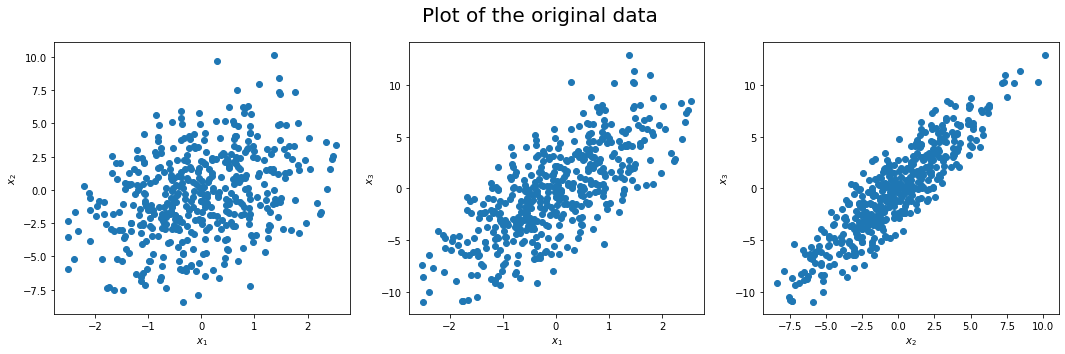

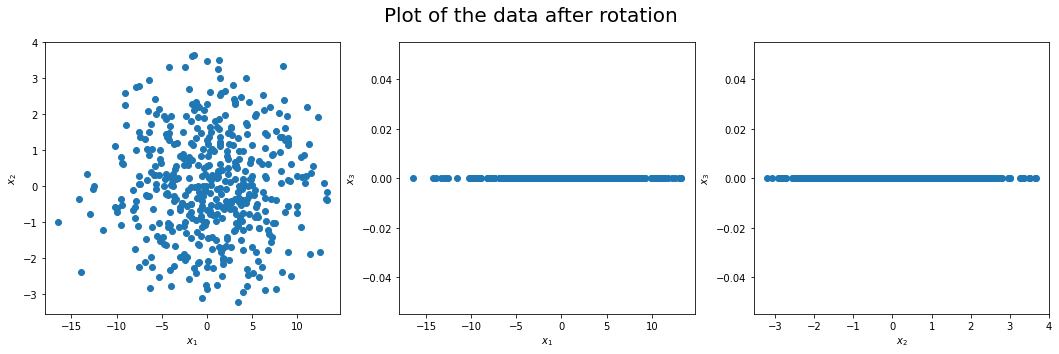

In [13]:
N = 456 #number of entries
x = np.zeros((3,N))
x[0,:] = np.random.normal(0,1,N)
x[1,:] = x[0,:] + np.random.normal(0,3,N)
x[2,:] = 2*x[0,:] + x[1,:]

#--------------------------------------------
val, V = la.eig(np.cov(x))
dec_indexes = np.argsort(val)[::-1]
V = V[:,dec_indexes]
val = val[dec_indexes]

#--------------------------------------------
U, spectrum, Vt = la.svd(x)
dec_indexes = np.argsort(spectrum)[::-1]
U = U[:,dec_indexes]
spectrum = spectrum[dec_indexes]
print("Eigenvectors of the covariance matrix:\n",V)
print("Matrix U retrieved from the SVD:\n",U)

print("The two matrixes are the same expect for small differences due to lack of Python precision.\n")

#--------------------------------------------
cov_trace = np.cov(x).trace()
print("The first principal component contributes for",np.real_if_close(val[0]*100/cov_trace),"%")
print("The second principal component contributes for",np.real_if_close(val[1]*100/cov_trace),"%")
print("The third principal component contributes for",100-np.real_if_close((val[0]+val[1])*100/cov_trace),"%")
print("The third principal component is the less important. This is explained by the fact that the third component is indeed")
print(" a linear combination of the other 2, so it doens't bring any information with it.\n")

#--------------------------------------------
new_x = np.dot(V.T,x)
new_x[2] = np.zeros((1,N))

#--------------------------------------------
ax = [i for i in range(6)]
fig, ax[0:3] = plt.subplots(1,3,figsize=(18,5))
fig.suptitle("Plot of the original data", fontsize=20)
fig1, ax[3:6] = plt.subplots(1,3,figsize=(18,5))
fig1.suptitle("Plot of the data after rotation", fontsize=20)

ax[0].scatter(x[0],x[1])
ax[0].set_ylabel("$x_2$")
ax[0].set_xlabel("$x_1$")

ax[1].scatter(x[0],x[2])
ax[1].set_ylabel("$x_3$")
ax[1].set_xlabel("$x_1$")

ax[2].scatter(x[1],x[2])
ax[2].set_ylabel("$x_3$")
ax[2].set_xlabel("$x_2$")

ax[3].scatter(new_x[0],new_x[1])
ax[3].set_ylabel("$x_2$")
ax[3].set_xlabel("$x_1$")

ax[4].scatter(new_x[0],new_x[2])
ax[4].set_ylabel("$x_3$")
ax[4].set_xlabel("$x_1$")

ax[5].scatter(new_x[1],new_x[2])
ax[5].set_ylabel("$x_3$")
ax[5].set_xlabel("$x_2$")

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standard deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

Eigenvectors of the covariance matrix:
 [[-0.11996644  0.56438287 -0.81674968]
 [-0.57481498 -0.71025212 -0.4063615 ]
 [-0.80944166  0.4207302   0.40962214]]
Matrix U retrieved from the SVD:
 [[-0.11940306  0.56460991 -0.81667531]
 [-0.57538331 -0.70969757 -0.40652601]
 [-0.8091211   0.42136089  0.40960718]]
The two matrixes are the same expect for small differences due to lack of Python precision.

The first principal component contributes for 93.48302342075888 %
The second principal component contributes for 6.488237574905385 %
The third principal component contributes for 0.028739004335733398 %
This time also x2 has a component of randomness, even though it has a very small variance. This makes the third principal
 component of this exercise a little more important than the previous one but still less than 1% over the total.



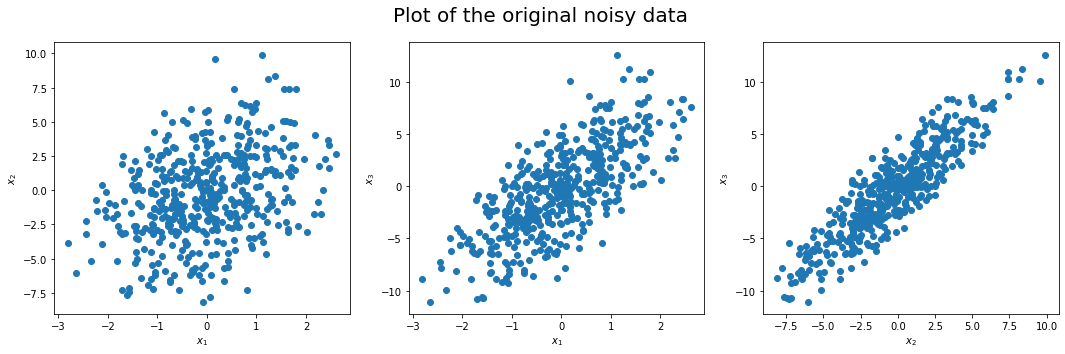

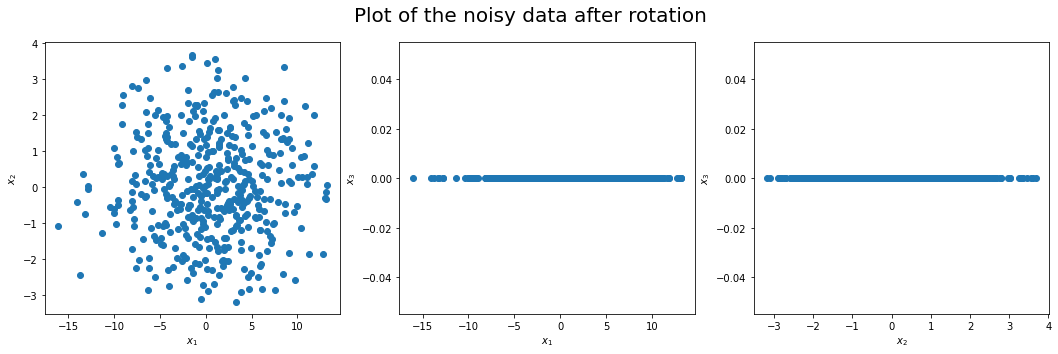

In [14]:
stds = np.random.randint(2,6,10)/100 #1/50=0.02, so I generate some integers from 2 to 5 and then divide them by 100
noises = np.zeros((10,N))
for i in range(10):
    noises[i] = np.random.normal(0,stds[i],N)
    for j in range(3):
        x[j] += noises[i]

#--------------------------------------------
val, V = la.eig(np.cov(x))
dec_indexes = np.argsort(val)[::-1]
V = V[:,dec_indexes]
val = val[dec_indexes]

#--------------------------------------------
U, spectrum, Vt = la.svd(x)
dec_indexes = np.argsort(spectrum)[::-1]
U = U[:,dec_indexes]
spectrum = spectrum[dec_indexes]
print("Eigenvectors of the covariance matrix:\n",V)
print("Matrix U retrieved from the SVD:\n",U)

print("The two matrixes are the same expect for small differences due to lack of Python precision.\n")

#--------------------------------------------
cov_trace = np.cov(x).trace()
print("The first principal component contributes for",np.real_if_close(val[0]*100/cov_trace),"%")
print("The second principal component contributes for",np.real_if_close(val[1]*100/cov_trace),"%")
print("The third principal component contributes for",100-np.real_if_close((val[0]+val[1])*100/cov_trace),"%")
print("This time also x2 has a component of randomness, even though it has a very small variance. This makes the third principal")
print(" component of this exercise a little more important than the previous one but still less than 1% over the total.\n")

new_x = np.dot(V.T,x)
new_x[2] = np.zeros((1,N))

#--------------------------------------------
ax = [i for i in range(6)]
fig, ax[0:3] = plt.subplots(1,3,figsize=(18,5))
fig.suptitle("Plot of the original noisy data", fontsize=20)
fig1, ax[3:6] = plt.subplots(1,3,figsize=(18,5))
fig1.suptitle("Plot of the noisy data after rotation", fontsize=20)

ax[0].scatter(x[0],x[1])
ax[0].set_ylabel("$x_2$")
ax[0].set_xlabel("$x_1$")

ax[1].scatter(x[0],x[2])
ax[1].set_ylabel("$x_3$")
ax[1].set_xlabel("$x_1$")

ax[2].scatter(x[1],x[2])
ax[2].set_ylabel("$x_3$")
ax[2].set_xlabel("$x_2$")

ax[3].scatter(new_x[0],new_x[1])
ax[3].set_ylabel("$x_2$")
ax[3].set_xlabel("$x_1$")

ax[4].scatter(new_x[0],new_x[2])
ax[4].set_ylabel("$x_3$")
ax[4].set_xlabel("$x_1$")

ax[5].scatter(new_x[1],new_x[2])
ax[5].set_ylabel("$x_3$")
ax[5].set_xlabel("$x_2$")

plt.show()

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


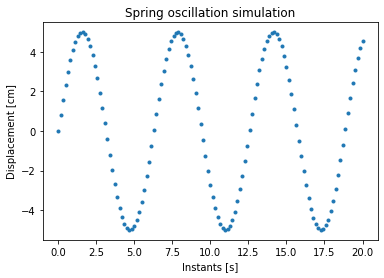

In [108]:
import math as m
def oscillating_spring(instant, amplitude=5, k=10, mass=10):
    displacement = amplitude*m.sin(instant*m.sqrt(k/mass)) #the argument is in radians
    return displacement
# def camera_rotation(theta,phi,displacement):
#     return

n = 3  #number of cameras
num_records = 125 #number of records
thetas = np.random.randint(0,180,n) #I assume one camera is looking along the x axis ==> theta and phi equals 0
phis = np.random.randint(0,360,n)

# cameras = 
starting_instant = 0
ending_instant = 20
instants = np.linspace(starting_instant, ending_instant, num_records)
spring_displacement = np.array(list(map(oscillating_spring,instants)))
plt.scatter(instants,spring_displacement,marker='.')
plt.title('Spring oscillation simulation')
plt.ylabel('Displacement [cm]')
plt.xlabel('Instants [s]')
# print(spring_displacement)

y_noise = np.random.normal(0,0.50,N)
# print(y_noise)

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [31]:
import csv

with open('/Users/Giacomo/Data/magic04.data') as file:
    reader = csv.reader(file, delimiter=',')
    line = next(reader)
    data = np.array(list(map(float,line[:-1])))
    category = np.array(line[-1])
    for line in csv.reader(file, delimiter=','):
        fLength, fWidth, fSize, fConc, fConc1,\
        fAsym, fM3long, fM3Trans, fAlpha, fDist= map(float,line[:-1])
        data = np.vstack((data,[fLength, fWidth, fSize, fConc, fConc1, fAsym, fM3long, fM3Trans, fAlpha, fDist]))
        category = np.vstack((category,line[-1]))

# print(data.shape)

In [41]:
data = data.reshape(data.shape[1],data.shape[0])
print(data.shape)

(19020, 1)
(10, 19020)


In [54]:
val, V = la.eig(np.cov(data))
dec_indexes = np.argsort(val)[::-1]
V = V[:,dec_indexes]
val = val[dec_indexes]
for i in range(10):
    print("The principal component", i+1,"contributes for", np.real_if_close(val[i]*100/sum(val)), "%")


The principal component 1 contributes for 71.84676902823605 %
The principal component 2 contributes for 5.344813028454809 %
The principal component 3 contributes for 4.979038824652856 %
The principal component 4 contributes for 4.596091059631396 %
The principal component 5 contributes for 3.6701697753568463 %
The principal component 6 contributes for 1.9984041647882118 %
The principal component 7 contributes for 1.9830771803251221 %
The principal component 8 contributes for 1.8912510375433362 %
The principal component 9 contributes for 1.8623422259823026 %
The principal component 10 contributes for 1.828043675029046 %
